El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un **modelo** que determine el **valor de mercado**.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor 
import catboost as cb
from xgboost import XGBRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

Los modelos, que evaluamos para predecir eficientemente el valor de un autómovil mediante sus específicaciones, fueron 6 en total. Usamos DecisionTreeRegressor, RandomForestRegressor, LinearRegression, CatBoost, LightGBM y XGBoost. Ajustamos hiperparámetros que define la profundidad del árbol para mejorar su calidad sigiiendo la recomendaciones de la docuemntación y observamos el error cradrático medio de cada uno en gráficas. También se evaluó el tiempo de entramiento y predicción para definir cuál sería el mejor modelo para este caso de estudio. El único modelo que no tuvo itearaciones y por ende gráfica fue LinearRegression ya que fue nuestro prueba de cordura.

## Funciones.

In [2]:
#Cargar los datos.
def read_csv(data):
    return pd.read_csv(data)

In [3]:
#Obtener información general.
def get_data_info(df):
    """Obtenemos la información general de un DataFrame incluyendo
    valores nulos de cada valor de las columnas y el tipo de objeto
    así como la descrpción estadística general.     

    Args:
        data (string): ruta del archivo csv.

    Returns:
        (DataFrame,DataFrame): Regresa tupla de dos elementos (df,df.describe).
    """
    #df = read_csv(data)
    
    print(df.sample(10),'\n')
    print(df.info(),'\n')
    print(df.describe(),'\n')
    
    df.columns = df.columns.str.lower()
    print('Se cambiaron columnas por minúsculas.\n')
    
    cont_null = 0
    col_with_nulls = []
    for column in df.columns:
        if df[column].isnull().sum() != 0:
            col_with_nulls.append(column)
            cont_null += 1 
            print(f"La columna {column}, que contiene "
                  f"valores de tipo {df[column].dtype}, "
                  f"tiene {df[column].isnull().sum()} valores nulos.\n")
    print(f"Hay {cont_null} columna(s) con valores vacíos.\n")
    
    df.hist(figsize=(10, 8))
    plt.grid(True)
    plt.show()
    
    return df

In [4]:
#Descartar filas con valores nulos.
def drop_index(data):
    return data.dropna(axis=0)

In [5]:
#Conveersión a valores de fecha.
def date_time(data,columns=list()):
    """Calcula la fecha descartando las hora.

    Args:
        data (_type_): _description_
        columns (_type_, optional): _description_. Defaults to list().

    Returns:
        _type_: _description_
    """
    for column in columns:
        data[column] = pd.to_datetime(data[column]).dt.date
    return data

In [6]:
# Dvidir el conjungot de datos en entrenamiento y prueba.
def split_data(data,test_size=0.3):
    X = data.drop(columns='price')
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"\nTamaño de las caracterísiticas de entrenamiento: {X_train.shape[0]}\n")
    print(f"\nTamaño de los objetivos de entrenamiento: {y_train.shape[0]}\n")
    print(f"\nTamaño de las caracterísiticas de prueba: {X_test.shape[0]}\n")
    print(f"\nTamaño de las pbjetivos de prueba: {y_test.shape[0]}\n")
    return X_train, X_test, y_train, y_test

In [7]:
#Codificación y Escalamiento.
def OEncoder_scale(features):
    encoder = OrdinalEncoder() #Codificación
    encoded_features = encoder.fit_transform(features) 
    scaler = StandardScaler() #Escalamiento
    scaled_features = pd.DataFrame(scaler.fit_transform(encoded_features),columns=features.columns)
    return scaled_features

In [8]:
#Grafica RMSE
def grafica_rmse(x):
    plt.plot(x)
    plt.plot(np.argmin(np.array(x)),np.min(np.array(x)), marker='*', markersize=15)
    plt.title(f"Error cuadrático medio con {len(x)+1} iteraciones.")
    plt.grid(True)
    print(f"El mejor RMSE es {np.min(np.array(x)):.2f} con max_depth = {np.argmin(np.array(x))+1}")

In [9]:
#Grafica R2
def grafica_r_2(x):
    plt.plot(x)
    plt.plot(np.argmax(np.array(x)),np.max(np.array(x)), marker='*', markersize=15)
    plt.title(f"Coeficiente de determinación con {len(x)+1} iteraciones.")
    plt.grid(True)
    print(f"El mejor R2 es {np.max(np.array(x)):.2f} con max_depth = {np.argmax(np.array(x))+1}")

In [10]:
#Grafica MAE
def grafica_mae(x):
    plt.plot(x)
    plt.plot(np.argmin(np.array(x)),np.min(np.array(x)), marker='*', markersize=15)
    plt.title(f"Error cuadrático medio con {len(x)+1} iteraciones.")
    plt.grid(True)
    print(f"El mejor MAE es {np.min(np.array(x)):.2f} con max_depth = {np.argmin(np.array(x))+1}")

In [11]:
# Arboles de dedeciones.
def DTR_model(X_train,X_test,y_train,y_test,iterations=2,random_state=4534):
    rmse_list = []
    r_2_list = []
    mae_list = []
    for i in range(iterations):
        print(f"Iteración {i+1}. max_depth={i+1}:\n")
        model = DecisionTreeRegressor(random_state=random_state,max_depth=(i+1))
        model.fit(X_train,y_train)  
        predictions = model.predict(X_test)
        rmse = mean_squared_error(y_test,predictions) ** 0.5
        r_2 = r2_score(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
        print(f"RMSE: {rmse}")
        print(f"R2: {r_2}")
        print(f"MAE:{mae}\n")
        rmse_list.append(rmse)
        r_2_list.append(r_2)
        mae_list.append(mae)
    return rmse_list,r_2_list,mae_list

In [12]:
# Random Forest
def Random_Forest(X_train,X_test,y_train,y_test,iterations=2,n_estimators=100,random_state=4534):
    rmse_list = []
    r_2_list = []
    mae_list = []
    for i in range(iterations):
        print(f"Iteración {i+1}. max_depth={i+1}:\n")
        model = RandomForestRegressor(n_estimators=n_estimators,max_depth=iterations,random_state=random_state)
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        rmse = mean_squared_error(y_test,predictions) ** 0.5
        r_2 = r2_score(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
        print(f"RMSE: {rmse}")
        print(f"R2: {r_2}")
        print(f"MAE:{mae}\n")
        rmse_list.append(rmse)
        r_2_list.append(r_2)
        mae_list.append(mae)
    return rmse_list,r_2_list,mae_list

In [13]:
#Modelo XGBoost
def Cat_Boost(X_train,X_test,y_train,y_test,iterations=2):
    rmse_list = []
    for i in range(iterations):
        print(f"Iteración {i+1}. max_depth={i+1}:\n")
        model = cb.CatBoostRegressor(depth=(i+1))
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_absolute_error(y_test,predictions))
        print(f"RMSE: {rmse}\n")
        rmse_list.append(rmse)
    return rmse_list

In [14]:
#Modelo LightGBM
def LGBM_Regressor(X_train,X_test,y_train,y_test,iterations=2,min_data_in_leaf=100):
    rmse_list = []
    for i in range(iterations):
        print(f"Iteración {i+1}. max_depth={i+1}:\n")
        model = LGBMRegressor(max_depth=(i+1),num_leaves=(i+1)*10,min_data_in_leaf=min_data_in_leaf,force_row_wise=True)
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_absolute_error(y_test,predictions))
        print(f"RMSE: {rmse}\n")
        rmse_list.append(rmse)
    return rmse_list

In [15]:
#Modelo XGBoost
def XGB_Regressor(X_train,X_test,y_train,y_test,iterations=2):
    rmse_list = []
    for i in range(iterations):
        print(f"Iteración {i+1}. max_depth={i+1}:\n")
        model = XGBRegressor(n_estimators=1000, max_depth=(i+1), eta=0.1, subsample=0.7, colsample_bytree=0.8)
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test,predictions))
        print(f"RMSE: {rmse}\n")
        rmse_list.append(rmse)
    return rmse_list

## 1. Preparación de datos

In [16]:
data = read_csv(r'..\..\..\datasets\car_data.csv')

In [17]:
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
289892,29/03/2016 20:46,1,sedan,1997,manual,75,golf,150000,0,petrol,volkswagen,NaN,29/03/2016 00:00,0,38685,04/04/2016 06:18
252707,16/03/2016 23:46,4200,sedan,1998,auto,193,3er,150000,1,lpg,bmw,no,16/03/2016 00:00,0,32825,22/03/2016 09:17
255817,24/03/2016 14:37,690,small,2003,manual,58,corsa,150000,7,petrol,opel,yes,24/03/2016 00:00,0,35305,24/03/2016 14:37
81403,22/03/2016 15:57,4990,small,2010,manual,68,other,40000,7,petrol,suzuki,no,22/03/2016 00:00,0,12207,29/03/2016 20:18
324988,16/03/2016 17:36,2999,small,2001,manual,125,lupo,150000,6,petrol,volkswagen,no,16/03/2016 00:00,0,80339,17/03/2016 15:45
256588,18/03/2016 13:46,1300,small,2002,manual,75,clio,125000,7,petrol,renault,no,18/03/2016 00:00,0,51067,18/03/2016 13:46
275401,17/03/2016 16:55,4700,sedan,2001,auto,194,s_klasse,150000,12,gasoline,mercedes_benz,no,17/03/2016 00:00,0,60433,22/03/2016 10:46
199367,25/03/2016 19:38,3399,NaN,2016,manual,0,c2,100000,9,petrol,citroen,no,25/03/2016 00:00,0,33689,07/04/2016 01:17
277249,26/03/2016 20:54,1999,wagon,2000,manual,136,3er,150000,7,gasoline,bmw,no,26/03/2016 00:00,0,38442,30/03/2016 00:47
308986,21/03/2016 10:48,2300,sedan,1998,manual,170,5er,150000,4,petrol,bmw,yes,21/03/2016 00:00,0,54634,02/04/2016 06:18


             DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
68759   23/03/2016 20:50   7700       wagon              2007    auto    179   
295249  26/03/2016 20:54   4250       small              2004  manual     64   
57666   15/03/2016 01:54   6499       sedan              2008  manual    105   
120129  19/03/2016 21:06    699       small              1999  manual     55   
270787  15/03/2016 17:49   6969       sedan              2006  manual    122   
77511   17/03/2016 10:52    700       wagon              1999  manual    100   
97726   16/03/2016 21:51  19300         bus              2014  manual    140   
224166  23/03/2016 23:37   1049       small              2000  manual     50   
138203  19/03/2016 16:45   2299       coupe              2003     NaN     52   
132209  05/04/2016 07:54    999         NaN              2016  manual     90   

           Model  Mileage  RegistrationMonth  FuelType       Brand  \
68759         a4   150000                  4  gas

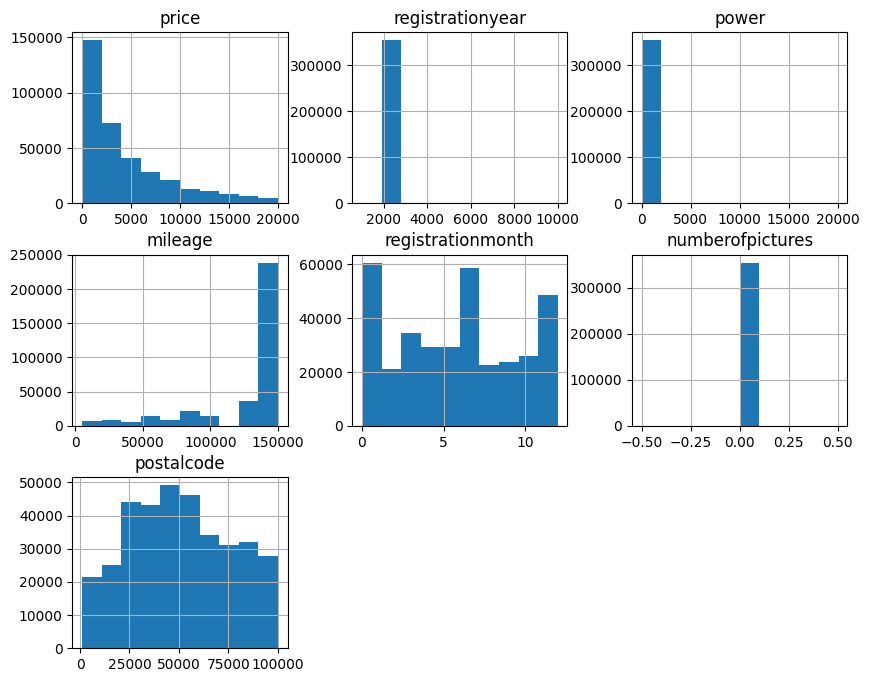

In [18]:
df = get_data_info(data)

Descartaremos las filas que tengan valores nulos.

In [19]:
df = drop_index(df)

             datecrawled  price vehicletype  registrationyear gearbox  power  \
101571  12/03/2016 11:36    600       small              1996  manual     60   
16422   13/03/2016 13:43   2500       small              2004  manual     75   
330138  28/03/2016 17:53   2100       small              2004  manual     75   
116872  18/03/2016 21:48   3450       small              2003  manual     75   
29522   04/04/2016 20:37   5600       sedan              2001    auto    193   
267484  10/03/2016 08:53   4590       small              2007  manual    101   
272122  19/03/2016 18:44  11300         bus              2010  manual    105   
340008  04/04/2016 18:41   1600       coupe              2000  manual    170   
235340  02/04/2016 01:57   2100       sedan              2002  manual    116   
290967  16/03/2016 09:47   3100       sedan              2002  manual    140   

         model  mileage  registrationmonth  fueltype       brand notrepaired  \
101571    golf   150000                

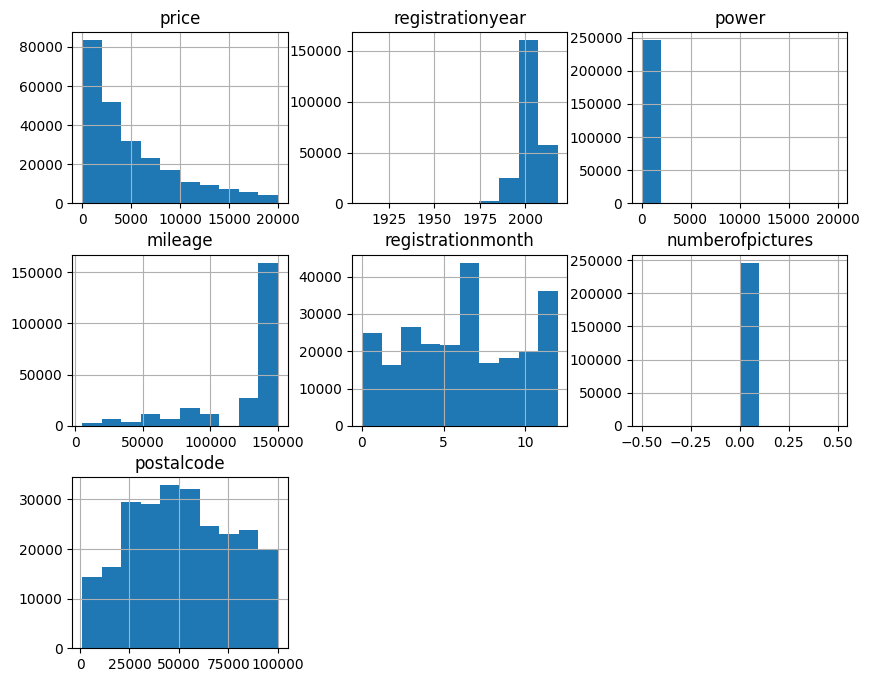

In [20]:
df_no_nulls = get_data_info(df)

¿En las columnas a valores de fecha? Las cambiamos al formato correspondiente.

In [21]:
columnas_fechas = ['datecrawled','datecreated','lastseen']
date_time(df_no_nulls,columnas_fechas)

C:\Users\CarlosVep\AppData\Local\Temp\ipykernel_19760\2597649656.py:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[column] = pd.to_datetime(data[column]).dt.date
C:\Users\CarlosVep\AppData\Local\Temp\ipykernel_19760\2597649656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = pd.to_datetime(data[column]).dt.date
C:\Users\CarlosVep\AppData\Local\Temp\ipykernel_19760\2597649656.py:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[column] = pd.to_datetime(data[column]).dt.date


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06
6,2016-04-01,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05
7,2016-03-21,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-04-02,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02,0,81825,2016-04-06
354362,2016-03-19,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19,0,96465,2016-03-19
354363,2016-03-27,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,0,26624,2016-03-29
354366,2016-03-05,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11


In [22]:
X_train, X_test, y_train, y_test = split_data(df_no_nulls)
scaled_X_train = OEncoder_scale(X_train)
scaled_X_test = OEncoder_scale(X_test)


Tamaño de las caracterísiticas de entrenamiento: 172069


Tamaño de los objetivos de entrenamiento: 172069


Tamaño de las caracterísiticas de prueba: 73745


Tamaño de las pbjetivos de prueba: 73745



En este primero paso descartamos filas que tuvieran valores nulos, quitando el **30%** del volumen del dataset. Se cambió el formato fehca en la columnas `datecrawled`, `datecreated` y `lastseen` y dividió el conjunto e datos de entranmeinto y prueba. Una vez hecho esto se codificaron y escalaron los datos del conjunto de entranmeinto y prueba.

## 2. Entrenamiento del modelo

Se entranarán diferentes modelos de regresión:

- Arboles de decisión.
- Random Forest.
- Regresión Lineal. (Prueba de cordura)

Al igual que modelos de potenciación de gradiantes.
- LightGBM. 
- CatBoost.
- XGBoost.

### Árboles de Decisión

In [23]:
DTR_rmse, DTR_r_2, DTR_mae = DTR_model(scaled_X_train,scaled_X_test,y_train,y_test,iterations=21,random_state=432)

Iteración 1. max_depth=1:

RMSE: 3621.575312079883
R2: 0.41391381190469523
MAE:2690.872565393353

Iteración 2. max_depth=2:

RMSE: 3205.8429443534965
R2: 0.5407481341990488
MAE:2349.3220808140454

Iteración 3. max_depth=3:

RMSE: 2847.0420713128697
R2: 0.637795188987905
MAE:2019.5979229777186

Iteración 4. max_depth=4:

RMSE: 2589.4295540130856
R2: 0.7003773465882153
MAE:1812.975880621393

Iteración 5. max_depth=5:

RMSE: 2432.5265309278975
R2: 0.7355877229167032
MAE:1687.9187400340008

Iteración 6. max_depth=6:

RMSE: 2330.807981774853
R2: 0.75723870913226
MAE:1598.5271401593673

Iteración 7. max_depth=7:

RMSE: 2249.1322329985874
R2: 0.7739542093819445
MAE:1513.2497271748475

Iteración 8. max_depth=8:

RMSE: 2172.809852645615
R2: 0.7890352532041305
MAE:1441.391835047534

Iteración 9. max_depth=9:

RMSE: 2107.810902141286
R2: 0.8014683565086951
MAE:1381.6918471700396

Iteración 10. max_depth=10:

RMSE: 2059.0723063310797
R2: 0.8105434432667298
MAE:1336.3557258249484

Iteración 11. max

Iniciando con Árboles de decisiones, tuvo un timepo de entranamiento de 12.6 segundos con 21 iteraciones.

### Random Forest

Random Forest tuvo un tiempo de entrenamiento mucho mayor. El tiempo de entrenamiento fue de 4 minutos con 53 segundos y se definieron 4 iteraciones.

In [24]:
RF_rmse, RF_r_2, RF_mae = Random_Forest(scaled_X_train,scaled_X_test,y_train,y_test,iterations=4,n_estimators=500,random_state=4534)

Iteración 1. max_depth=1:

RMSE: 2546.953768612673
R2: 0.7101264637583858
MAE:1783.754024902038

Iteración 2. max_depth=2:

RMSE: 2546.953768612673
R2: 0.7101264637583858
MAE:1783.754024902038

Iteración 3. max_depth=3:

RMSE: 2546.953768612673
R2: 0.7101264637583858
MAE:1783.754024902038

Iteración 4. max_depth=4:

RMSE: 2546.953768612673
R2: 0.7101264637583858
MAE:1783.754024902038



### Regresión Lineal

Nuestra prueba de cordura tuvo un timepo de respuesta instantáneo.

In [25]:
LR_model = LinearRegression()
LR_model.fit(scaled_X_train,y_train)

LinearRegression()

### LightGBM


Con 60 iteraciones el entraniemto del modelo LightGBM tomó 1 minuto.

In [26]:
lgmb_rmse = LGBM_Regressor(scaled_X_train,scaled_X_test,y_train,y_test,iterations=60,min_data_in_leaf=160)

Iteración 1. max_depth=1:

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 14
[LightGBM] [Info] Start training from score 5122.569359
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
RMSE: 41.1430410014704

Iteración 2. max_depth=2:

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 172069, number of used fea

### CatBoost

El timpo de entramiento del modelo Catboost con 14 iteraciones fue de 7 minutos 11 segundos.

In [27]:
rmse_cb = Cat_Boost(scaled_X_test,scaled_X_train,y_test,y_train,iterations=14)

Iteración 1. max_depth=1:

Learning rate set to 0.080776
0:	learn: 4576.3108504	total: 170ms	remaining: 2m 49s
1:	learn: 4441.5227586	total: 172ms	remaining: 1m 26s
2:	learn: 4322.8092363	total: 174ms	remaining: 57.9s
3:	learn: 4216.7158420	total: 176ms	remaining: 43.8s
4:	learn: 4122.2693417	total: 178ms	remaining: 35.4s
5:	learn: 4039.3643531	total: 179ms	remaining: 29.7s
6:	learn: 3964.3686541	total: 181ms	remaining: 25.7s
7:	learn: 3894.2363816	total: 183ms	remaining: 22.7s
8:	learn: 3830.4407368	total: 185ms	remaining: 20.3s
9:	learn: 3770.5551065	total: 186ms	remaining: 18.4s
10:	learn: 3711.3141702	total: 188ms	remaining: 16.9s
11:	learn: 3657.0604829	total: 189ms	remaining: 15.6s
12:	learn: 3603.4166968	total: 191ms	remaining: 14.5s
13:	learn: 3552.8914746	total: 193ms	remaining: 13.6s
14:	learn: 3506.0687639	total: 194ms	remaining: 12.8s
15:	learn: 3462.2226779	total: 196ms	remaining: 12.1s
16:	learn: 3419.2044810	total: 198ms	remaining: 11.4s
17:	learn: 3380.2512639	total: 20

### XGBoost

Con 14 ietraciones, el modelo XGBoost con 14 interaciones tuvo un tiempo de entranamiento de 2 minutos 5 segundos.

In [28]:
xgb_rmse = XGB_Regressor(scaled_X_test,scaled_X_train,y_test,y_train,iterations=14)

Iteración 1. max_depth=1:

RMSE: 2369.675857152494

Iteración 2. max_depth=2:

RMSE: 2092.5565748207155

Iteración 3. max_depth=3:

RMSE: 2034.0833989732298

Iteración 4. max_depth=4:

RMSE: 1983.1971749359154

Iteración 5. max_depth=5:

RMSE: 1997.7360938364322

Iteración 6. max_depth=6:

RMSE: 1976.060821721524

Iteración 7. max_depth=7:

RMSE: 1992.1252858062642

Iteración 8. max_depth=8:

RMSE: 1987.981144138373

Iteración 9. max_depth=9:

RMSE: 1986.0941217621603

Iteración 10. max_depth=10:

RMSE: 1982.0260695907034

Iteración 11. max_depth=11:

RMSE: 2000.0711659311366

Iteración 12. max_depth=12:

RMSE: 2007.0970927890432

Iteración 13. max_depth=13:

RMSE: 2028.7312553882334

Iteración 14. max_depth=14:

RMSE: 2045.9594613240963



## 3. Análisis del modelo

### Árboles de Decisión.

El mejor RMSE es 2053.29 con max_depth = 11


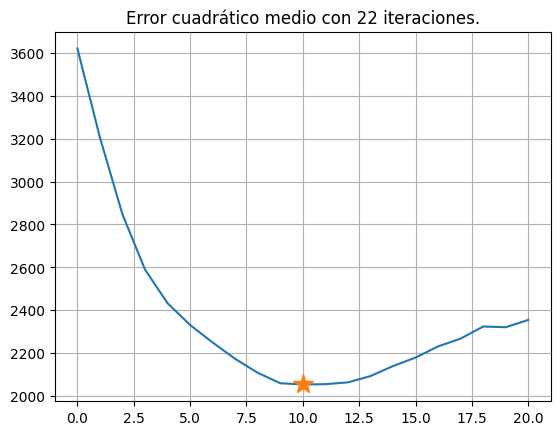

In [29]:
grafica_rmse(DTR_rmse)

### Random Forest

El mejor RMSE es 2546.95 con max_depth = 1


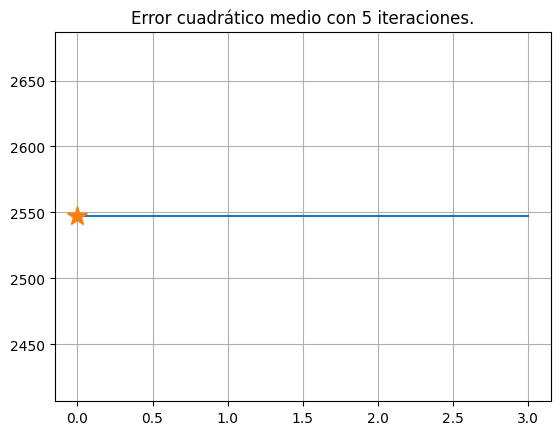

In [30]:
grafica_rmse(RF_rmse)

### Regresión Lineal

In [31]:
rmse = np.sqrt(mean_squared_error(y_test,LR_model.predict(scaled_X_test)))

print(f"RMSE Regresión Lineal: {rmse:.2f}")

RMSE Regresión Lineal: 2987.60


### LightGBM

El mejor RMSE es 31.44 con max_depth = 59


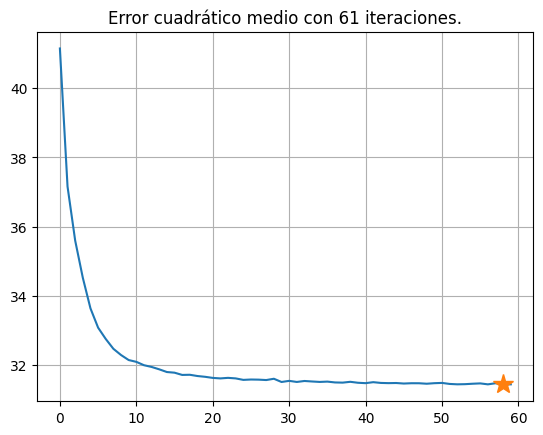

In [32]:
grafica_rmse(lgmb_rmse)

### CatBoost

El mejor RMSE es 31.70 con max_depth = 10


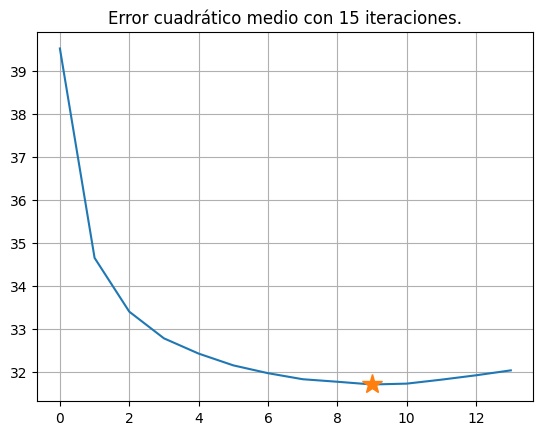

In [33]:
grafica_rmse(rmse_cb)

### XGBoost

El mejor RMSE es 1976.06 con max_depth = 6


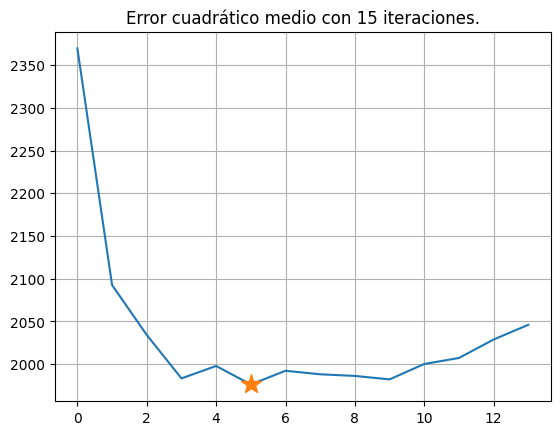

In [34]:
grafica_rmse(xgb_rmse)

## Resultados.

El modelo de Árboles tuvo un tiempo de entrenamiento rápido pero seleccionando el RMSE menor de cada iteración aún es alto y se puede mejorar. El RMSE de este modelo indica que el modelo se puede equivocar +/- 2053.29 pesos sobre el valor del vehículo. Queremos minizar este valor entonces es importante visualizar los otros modelos.

Calculando el RMSE del model Random Forest obtuvimos como resultado que además de tener un alto timepo de entrenamiento, el RMSE es mayor al modelo anterior (Árboles). No alcanzamos nuestro objetivo con este modelo.

En nuestra prueba de cordura siendo nuestro modelo regresión lineal, obtuvimos un RMSE de 2987 nada mal pero no lo suficientemente bueno para llevarlo a producción.

De los resultados con los resultados de potenciación del gradiente. Empezamos con LightGBM, que aunque fue el modelo con más iteraciones el tiempo y el rmse dieron mbuenos resultados con 1 minuto y 31.44 respectivamente.

El CatBoost es el modelo que mas se tardó en ser entrenado no obstante el RMSE que se obtuvo fue 31.7.

XGBOost no tuvo un tiempo de entrnamiento y un bune RMSE para ser considerado para escogerlo como el modelo óptimo.

Poniendo estos criterios en una tabla.

| Modelos          | Tiempo      | RMSE     | Iteraciones |
|:-----------------|:-----------:|---------:|------------:|
| Árboles          | 12.6 s      | 2 053.29 |    22       |
| Forest           | 4 min 53 s  | 2 546.95 |    5        |
| Regresión Lineal | 0.1 s       | 2 987    |    61       |
| LightGBM         | 1 min 1.6 s | 31.44    |    10       |
| CatBoost         | 7 min 4.3 s | 31.7     |    15       |
| XGBoost          | 2 min 5.6 s | 1 976.06 |    15       |


**El mejor modelo que no puede ayudar a dar mejores resultados sería LightGBM.**

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en orden de ejecución
- [x]  Los datos han sido descargados y preparados
- [x]  Los modelos han sido entrenados
- [x]  Se realizó el análisis de velocidad y calidad de los modelos